In [4]:
name = "Esad Boran"
name

'Esad Boran'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os
import zipfile

# Path to the zip file that will be downloaded and extracted
zip_path = '/content/drive/MyDrive/PA3.zip'
extract_path = '/content/dataset/'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


<!DOCTYPE html>
<html>
<head>
<style>
* {
  box-sizing: border-box;
}

.row {
  margin-left:-5px;
  margin-right:-5px;
}
  
.column {
  float: left;
  width: 50%;
  padding: 5px;
}

/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}

table {
  border-collapse: collapse;
  border-spacing: 0;
  width: 100%;
  border: 1px solid #ddd;
}

th, td {
  text-align: left;
  padding: 16px;
}

tr:nth-child(even) {
  background-color: #f2f2f2;
}
</style>
</head>
<body>

<h2 style="text-align: center" >BBM418 : Fundamentals of Computer Vision Lab.</h2>
<h4 style="text-align: center">Assignment 3 : Image Classification with Convolutional Neural Networks
</h4>
<br>
<div class="row">
  <div class="column">
    <table>
      <tr>
        <th>First Name</th>
        <th>Last Name</th>
        <th>No</th>
      </tr>
      <tr>
        <td>Esad</td>
        <td>Boran</td>
        <td>21827206</td>
      </tr>
    </table>
  </div>
</div>

</body>
</html>

# 1. Introduction

This assignment involves conducting an analysis on Convolutional Neural Networks (CNNs). Initially, a CNN model is developed from the ground up to gain a better understanding of its architecture. Subsequently, transfer learning is employed using a CNN-based approach. The results obtained from this process are carefully analyzed. Throughout the entire assignment, the PyTorch library is utilized, and enhancements are made using Colab.


# 2. Required Libraries


In [52]:
import numpy as np
import pandas as pd
import seaborn as sn
import random
import os
import re
import torch
import matplotlib.pyplot as plt


#Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from PIL import Image

#Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torchvision import models

# 3. Dataset

There are 8 categories; Amoeba, Euglena, Hydra, Paramecium, Rod bacteria, Spherical bacteria, Spiral bacteria and Yeast. The training set includes  480 images, the validation set includes 160 images, and the test set includes 160 images. There are a total of 800 images,100 from each class.

In [75]:
folder_path = '/content/dataset/Micro_Organism'
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    print('Folder:', file_name)

Folder: Paramecium
Folder: Euglena
Folder: Spherical_bacteria
Folder: Hydra
Folder: Amoeba
Folder: Rod_bacteria
Folder: Spiral_bacteria
Folder: Yeast



## 3.1 Dataset Splitting

To ensure better learning, it is important to have a well-organized dataset. Here, we arrange the dataset into training, validation, and test sets. The train_ratio, val_ratio, and test_ratio variables represent the desired proportions of each set. Random shuffling of images is performed to avoid any biases. The number of images in each set is determined based on these proportions. Finally, the file paths and corresponding labels are stored in train_set, val_set, and test_set lists.

In [76]:
import random


# Ratio of train,test,validation of data
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_set = []
val_set = []
test_set = []



folder_path = '/content/dataset/Micro_Organism'
class_folders = os.listdir(folder_path)


for class_folder in class_folders:
    class_path = os.path.join(folder_path, class_folder)
    images = os.listdir(class_path)
    random.shuffle(images)  # # Shuffle image
    
    num_images = len(images)
    num_train = int(train_ratio * num_images)
    num_val = int(val_ratio * num_images)
    
    train_set.extend([(os.path.join(class_folder, img), class_folder) for img in images[:num_train]])
    val_set.extend([(os.path.join(class_folder, img), class_folder) for img in images[num_train:num_train + num_val]])
    test_set.extend([(os.path.join(class_folder, img), class_folder) for img in images[num_train + num_val:]])


The code shuffles the train_set, val_set, and test_set lists using random.shuffle() to randomize the order of the samples within each set. Then, the file paths and corresponding labels are written to separate text files. The train.txt file contains the paths and labels of samples in the train_set, the val.txt file contains those of the val_set, and the test.txt file contains those of the test_set.

In [77]:
random.shuffle(train_set)
random.shuffle(val_set)
random.shuffle(test_set)

with open('train.txt', 'w') as f:
    for item in train_set:
        f.write(item[0] + ' ' + item[1] + '\n')

with open('val.txt', 'w') as f:
    for item in val_set:
        f.write(item[0] + ' ' + item[1] + '\n')

with open('test.txt', 'w') as f:
    for item in test_set:
        f.write(item[0] + ' ' + item[1] + '\n')

# 4. PART 1 - Modeling and Training a CNN classifier from Scratch 


## 4.1 Models


CNNModel: This model does not have residual connections. It consists of several convolutional layers followed by max pooling and fully connected layers. The forward method defines the forward pass of the model, where input data flows through the convolutional layers, average pooling, and fully connected layers, ultimately producing the output.


ResidualCNNModel: This model incorporates residual connections. It starts with a convolutional layer, followed by several residual blocks. Each residual block contains two convolutional layers with a residual connection between them. The forward method performs the forward pass through the convolutional layers, residual blocks, average pooling, and fully connected layers, producing the output.

Both models take input images of size 3xHxW (RGB images) and output  for the specified number of classes.

Loss Function and Optimizer Definition( In training and evaluation part ): The loss function (criterion) is set to nn.CrossEntropyLoss(), which is commonly used for multiclass classification problems. The optimizer (optimizer) is defined as Adam optimizer, optimizing the model parameters with a given learning rate (learning_rate).

In [ ]:
import torch
import torch.nn as nn

# CNN model without residual connections
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            #Max-Pool
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity
        out = self.relu(out)
        return out

class ResidualCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(ResidualCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.residual_blocks = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [ ]:
# These values will change later.

input_size = 52

# Number of classes in the dataset, we use it for output layer.
num_classes = 8 

# Batch size for training.
batch_size = 64

# Number of epochs to train for.
num_epochs = 100

# Learning rate for training.
learning_rate = 0.001


## 4.2 CustomDataset for Image Classification with Data Transformation


This code defines a CustomDataset class for image classification tasks. It extends the torch.utils.data.Dataset class. The dataset loads image files from a specified file path and performs data transformations on the images.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Resize the image to a specific size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
])

class CustomDataset(Dataset):
    def __init__(self, file_path, root_dir, transform=None):
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        
        # Open the file containing image paths and labels
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                image_path, label = line.strip().split()
                self.data.append((image_path, label))
        
        # Encode labels using LabelEncoder
        labels = [label for _, label in self.data]
        self.label_encoder.fit(labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        full_path = self.root_dir + '/' + file_path
        
        # Open the image using PIL's Image class
        img = Image.open(full_path)
        
        # Convert the image to RGB mode if it's not already
        img = img.convert("RGB")
        
        # Apply the specified transformations to the image
        img_tensor = transform(img)
        
        # Encode the label using the label_encoder
        label = self.label_encoder.transform([label])[0]
        
        return img_tensor.float(), torch.tensor(label)
    

The provided code segment demonstrates the creation of data loaders for training, validation, and testing data sets using the CustomDataset class defined earlier. The data loaders enable efficient loading of data in batches during model training and evaluation.

In [ ]:
# File paths
train_file_path = 'train.txt'
val_file_path = 'val.txt'
test_file_path = 'test.txt'
root_dir = '/content/dataset/Micro_Organism'


# Creating datasets
train_dataset = CustomDataset(train_file_path, root_dir, transform=transform)
val_dataset = CustomDataset(val_file_path, root_dir, transform=transform)
test_dataset = CustomDataset(test_file_path, root_dir, transform=transform)


# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



# Create training and validation dataloaders
dataloaders_dict = {'train': train_loader, 
                    'val': validation_loader,
                    'test':test_loader}

## 4.3 Training and Validation Loop with Model Training and Evaluation


The provided code segment implements a training and validation loop (train_and_validate function) for a given model using the training and validation data sets. It performs model training and evaluation, tracking validation losses and accuracies throughout the process. The function returns the validation losses, validation accuracies, and the best model obtained during training.


<b>Data Loader Creation</b>: Data loaders for training and validation (train_loader and val_loader) are created using the DataLoader class from PyTorch. The training data loader shuffles the data (shuffle=True), while the validation data loader does not.

<b>Loss Function and Optimizer Definition</b>: The loss function (criterion) is set to nn.CrossEntropyLoss(), which is commonly used for multiclass classification problems. The optimizer (optimizer) is defined as Adam optimizer, optimizing the model parameters with a given learning rate (learning_rate).


<b>Training Loop</b>: The function loops through each epoch in the specified number of epochs (num_epochs). For each epoch, it sets the model to training mode (model.train()) and iterates over the training data loader to perform the forward pass, calculate the loss, and optimize the model parameters.

<b>Validation</b>: After each epoch of training, the function switches the model to evaluation mode (model.eval()) and evaluates the model's performance on the validation data. It calculates the validation loss and accuracy by iterating over the validation data loader. The validation loss is computed as the average loss per sample, and the validation accuracy is calculated as the ratio of correct predictions to the total number of samples.

<b>Best Model Selection</b>: The function checks if the current model has achieved the best validation loss so far. If it has, the best_validation_loss is updated, and a deep copy of the model's state dict is saved in best_model.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

def train_and_validate(model, train_dataset, val_dataset, batch_size, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create DataLoader for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    validation_losses = []
    validation_accuracies = []

    best_validation_loss = float('inf')
    best_model = copy.deepcopy(model.state_dict())

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate validation loss
                total_loss += loss.item() * images.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        validation_loss = total_loss / total_samples
        validation_accuracy = total_correct / total_samples

        # Append current validation loss and accuracy to the history arrays
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Check if current model has the best validation loss
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model = copy.deepcopy(model.state_dict())

        # Print validation metrics for the current epoch
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")


    # load best model weights
    model.load_state_dict(best_model)
    return validation_losses, validation_accuracies, model

## 4.4  Hyperparameter Tuning for CNN and Residual Model with Varying Batch Size and Learning Rate


In this experiment, a total of 8 attempts were made to train and evaluate a CNN  adn Residual model using different combinations of batch sizes and learning rates. The goal was to find the best performing configuration for the model.

The following combinations of hyperparameters were tested:


### 4.4.1 Batch Size: 64, Learning Rate: 0.0001 Model: CNNModel

In [ ]:
cnn_model = CNNModel(8)
vl_64_low, va_64_low, model_64_low = train_and_validate(cnn_model, train_dataset, val_dataset, 64, 10, 0.0001)
np.save('files/vl_64_low.npy', vl_64_low)
np.save('files/va_64_low.npy', va_64_low)
torch.save(model_64_low.state_dict(), 'files/model_64_low.pt')

Epoch [1/10], Validation Loss: 2.0305, Validation Accuracy: 0.2115
Epoch [2/10], Validation Loss: 2.0186, Validation Accuracy: 0.2115
Epoch [3/10], Validation Loss: 1.9680, Validation Accuracy: 0.2115
Epoch [4/10], Validation Loss: 1.9667, Validation Accuracy: 0.2821
Epoch [5/10], Validation Loss: 1.8696, Validation Accuracy: 0.2436
Epoch [6/10], Validation Loss: 1.8345, Validation Accuracy: 0.3205
Epoch [7/10], Validation Loss: 1.8418, Validation Accuracy: 0.3462
Epoch [8/10], Validation Loss: 1.8408, Validation Accuracy: 0.2949
Epoch [9/10], Validation Loss: 1.8061, Validation Accuracy: 0.3077
Epoch [10/10], Validation Loss: 1.7733, Validation Accuracy: 0.3397


### 4.4.2 Batch Size: 128, Learning Rate: 0.0001 Model: CNNModel

In [ ]:
cnn_model = CNNModel(8)
vl_128_low, va_128_low, model_128_low = train_and_validate(cnn_model, train_dataset, val_dataset, 128, 10, 0.0001)
np.save('files/vl_128_low.npy', vl_128_low)
np.save('files/va_128_low.npy', va_128_low)
torch.save(model_128_low.state_dict(), 'files/model_128_low.pt')

Epoch [1/10], Validation Loss: 2.0333, Validation Accuracy: 0.2115
Epoch [2/10], Validation Loss: 2.0330, Validation Accuracy: 0.2115
Epoch [3/10], Validation Loss: 1.9896, Validation Accuracy: 0.2115
Epoch [4/10], Validation Loss: 1.9579, Validation Accuracy: 0.2115
Epoch [5/10], Validation Loss: 1.9229, Validation Accuracy: 0.2115
Epoch [6/10], Validation Loss: 1.9013, Validation Accuracy: 0.2692
Epoch [7/10], Validation Loss: 1.9362, Validation Accuracy: 0.3013
Epoch [8/10], Validation Loss: 1.9085, Validation Accuracy: 0.3205
Epoch [9/10], Validation Loss: 1.8825, Validation Accuracy: 0.3526
Epoch [10/10], Validation Loss: 1.8661, Validation Accuracy: 0.3782


### 4.4.3 Batch Size: 64, Learning Rate: 0.001 Model: CNNModel

In [ ]:
cnn_model = CNNModel(8)
vl_64_high, va_64_high, model_64_high = train_and_validate(cnn_model, train_dataset, val_dataset, 64, 10, 0.001)
np.save('files/vl_64_high.npy', vl_64_high)
np.save('files/va_64_high.npy', va_64_high)
torch.save(model_64_high.state_dict(), 'files/model_64_high.pt')

Epoch [1/10], Validation Loss: 2.0462, Validation Accuracy: 0.2115
Epoch [2/10], Validation Loss: 2.0476, Validation Accuracy: 0.2115
Epoch [3/10], Validation Loss: 2.0109, Validation Accuracy: 0.2115
Epoch [4/10], Validation Loss: 1.9721, Validation Accuracy: 0.2115
Epoch [5/10], Validation Loss: 1.9718, Validation Accuracy: 0.2115
Epoch [6/10], Validation Loss: 2.0008, Validation Accuracy: 0.2179
Epoch [7/10], Validation Loss: 1.9477, Validation Accuracy: 0.2564
Epoch [8/10], Validation Loss: 1.8753, Validation Accuracy: 0.2628
Epoch [9/10], Validation Loss: 1.9155, Validation Accuracy: 0.2179
Epoch [10/10], Validation Loss: 1.8521, Validation Accuracy: 0.2500


### 4.4.4 Batch Size: 128, Learning Rate: 0.001 Model: CNNModel

In [ ]:
cnn_model = CNNModel(8)
vl_128_high, va_128_high, model_128_high = train_and_validate(cnn_model, train_dataset, val_dataset, 128,10, 0.001)
np.save('files/vl_128_high.npy', vl_128_high)
np.save('files/va_128_high.npy', va_128_high)
torch.save(model_128_high.state_dict(), 'files/model_128_high.pt')

Epoch [1/10], Validation Loss: 2.0746, Validation Accuracy: 0.1923
Epoch [2/10], Validation Loss: 2.0588, Validation Accuracy: 0.1923
Epoch [3/10], Validation Loss: 2.0434, Validation Accuracy: 0.1923
Epoch [4/10], Validation Loss: 2.0438, Validation Accuracy: 0.1923
Epoch [5/10], Validation Loss: 2.0248, Validation Accuracy: 0.2115
Epoch [6/10], Validation Loss: 2.0221, Validation Accuracy: 0.2436
Epoch [7/10], Validation Loss: 2.0187, Validation Accuracy: 0.2115
Epoch [8/10], Validation Loss: 2.0113, Validation Accuracy: 0.2115
Epoch [9/10], Validation Loss: 1.9682, Validation Accuracy: 0.2372
Epoch [10/10], Validation Loss: 2.0511, Validation Accuracy: 0.2436


### 4.4.5 Batch Size: 64, Learning Rate: 0.0001 Model: ResidualCNNModel

In [ ]:
residual_model = ResidualCNNModel(8)
residual_vl_64_low, residual_va_64_low, residual_model_64_low = train_and_validate(residual_model, train_dataset, val_dataset, 64,10, 0.0001)
np.save('files/residual_vl_64_low.npy', residual_vl_64_low)
np.save('files/residual_va_64_low.npy', residual_va_64_low)
torch.save(residual_model_64_low.state_dict(), 'files/residual_model_64_low.pt')

Epoch [1/10], Validation Loss: 2.0457, Validation Accuracy: 0.2179
Epoch [2/10], Validation Loss: 2.0159, Validation Accuracy: 0.2244
Epoch [3/10], Validation Loss: 1.9900, Validation Accuracy: 0.2308
Epoch [4/10], Validation Loss: 1.9589, Validation Accuracy: 0.2500
Epoch [5/10], Validation Loss: 1.9320, Validation Accuracy: 0.2885
Epoch [6/10], Validation Loss: 1.9013, Validation Accuracy: 0.2756
Epoch [7/10], Validation Loss: 1.8820, Validation Accuracy: 0.3077
Epoch [8/10], Validation Loss: 1.8828, Validation Accuracy: 0.3141
Epoch [9/10], Validation Loss: 1.8982, Validation Accuracy: 0.3077
Epoch [10/10], Validation Loss: 1.8775, Validation Accuracy: 0.2885


### 4.4.6 Batch Size: 128, Learning Rate: 0.0001 Model: ResidualCNNModel

In [ ]:
residual_model = ResidualCNNModel(8)
residual_vl_128_low, residual_va_128_low, residual_model_128_low = train_and_validate(residual_model, train_dataset, val_dataset, 128,10, 0.0001)
np.save('files/residual_vl_128_low.npy', residual_vl_128_low)
np.save('files/residual_va_128_low.npy', residual_va_128_low)
torch.save(residual_model_128_low.state_dict(), 'files/residual_model_128_low.pt')

Epoch [1/10], Validation Loss: 2.0356, Validation Accuracy: 0.2244
Epoch [2/10], Validation Loss: 2.0237, Validation Accuracy: 0.2244
Epoch [3/10], Validation Loss: 2.0119, Validation Accuracy: 0.2436
Epoch [4/10], Validation Loss: 1.9981, Validation Accuracy: 0.2372
Epoch [5/10], Validation Loss: 1.9779, Validation Accuracy: 0.3205
Epoch [6/10], Validation Loss: 1.9508, Validation Accuracy: 0.3077
Epoch [7/10], Validation Loss: 1.9349, Validation Accuracy: 0.2628
Epoch [8/10], Validation Loss: 1.9178, Validation Accuracy: 0.2628
Epoch [9/10], Validation Loss: 1.8961, Validation Accuracy: 0.2756
Epoch [10/10], Validation Loss: 1.8847, Validation Accuracy: 0.2692


### 4.4.7 Batch Size: 64, Learning Rate: 0.001 Model: ResidualCNNModel

In [ ]:
residual_model = ResidualCNNModel(8)
residual_vl_64_high, residual_va_64_high, residual_model_64_high = train_and_validate(residual_model, train_dataset, val_dataset, 64,10, 0.001)
np.save('files/residual_vl_64_high.npy', residual_vl_64_high)
np.save('files/residual_va_64_high.npy', residual_va_64_high)
torch.save(residual_model_64_high.state_dict(), 'files/residual_model_64_high.pt')

Epoch [1/10], Validation Loss: 2.0272, Validation Accuracy: 0.2179
Epoch [2/10], Validation Loss: 1.9161, Validation Accuracy: 0.2821
Epoch [3/10], Validation Loss: 1.9451, Validation Accuracy: 0.2564
Epoch [4/10], Validation Loss: 1.9423, Validation Accuracy: 0.3013
Epoch [5/10], Validation Loss: 1.9917, Validation Accuracy: 0.3205
Epoch [6/10], Validation Loss: 1.9987, Validation Accuracy: 0.3205
Epoch [7/10], Validation Loss: 2.1612, Validation Accuracy: 0.3654
Epoch [8/10], Validation Loss: 2.1729, Validation Accuracy: 0.2500
Epoch [9/10], Validation Loss: 2.3460, Validation Accuracy: 0.2436
Epoch [10/10], Validation Loss: 2.3596, Validation Accuracy: 0.3269


### 4.4.8 Batch Size: 128, Learning Rate: 0.001 Model: ResidualCNNModel

In [ ]:
residual_model = ResidualCNNModel(8)
residual_vl_128_high, residual_va_128_high, residual_model_128_high = train_and_validate(residual_model, train_dataset, val_dataset, 128,10, 0.001)
np.save('files/residual_vl_128_high.npy', residual_vl_128_high)
np.save('files/residual_va_128_high.npy', residual_va_128_high)
torch.save(residual_model_128_high.state_dict(), 'files/residual_model_128_high.pt')

Epoch [1/10], Validation Loss: 1.9996, Validation Accuracy: 0.2115
Epoch [2/10], Validation Loss: 1.9715, Validation Accuracy: 0.2115
Epoch [3/10], Validation Loss: 1.9295, Validation Accuracy: 0.3013
Epoch [4/10], Validation Loss: 1.9540, Validation Accuracy: 0.3077
Epoch [5/10], Validation Loss: 1.9880, Validation Accuracy: 0.2692
Epoch [6/10], Validation Loss: 1.9871, Validation Accuracy: 0.2244
Epoch [7/10], Validation Loss: 2.0122, Validation Accuracy: 0.3333
Epoch [8/10], Validation Loss: 2.0076, Validation Accuracy: 0.2885
Epoch [9/10], Validation Loss: 2.1523, Validation Accuracy: 0.2756
Epoch [10/10], Validation Loss: 2.1606, Validation Accuracy: 0.2500


## 4.5 Comparison of Loss and Accuracy for Different Learning Rates and Batch Sizes in CNN and ResidualCNNModel


### 4.5.1 Graph 1: Comparison of Loss and Accuracy for Different Learning Rates (Batch Size: 128) in CNN Model

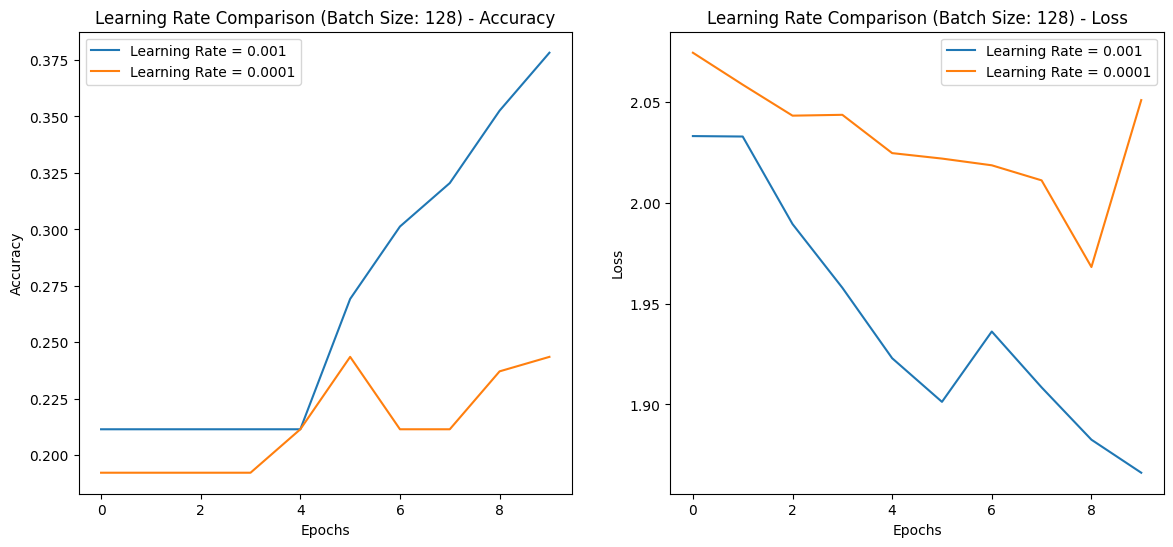

In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Accuracy Comparison
ax1.plot(va_128_low, label='Learning Rate = 0.001')
ax1.plot(va_128_high, label='Learning Rate = 0.0001')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Learning Rate Comparison (Batch Size: 128) - Accuracy')
ax1.legend()

# Subplot 2: Loss Comparison
ax2.plot(vl_128_low, label='Learning Rate = 0.001')
ax2.plot(vl_128_high, label='Learning Rate = 0.0001')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Learning Rate Comparison (Batch Size: 128) - Loss')
ax2.legend()


plt.show()

### 4.5.2 Graph 2: Comparison of Loss and Accuracy for Different Batch size (Learning Rate = 0.0001) in CNNModel

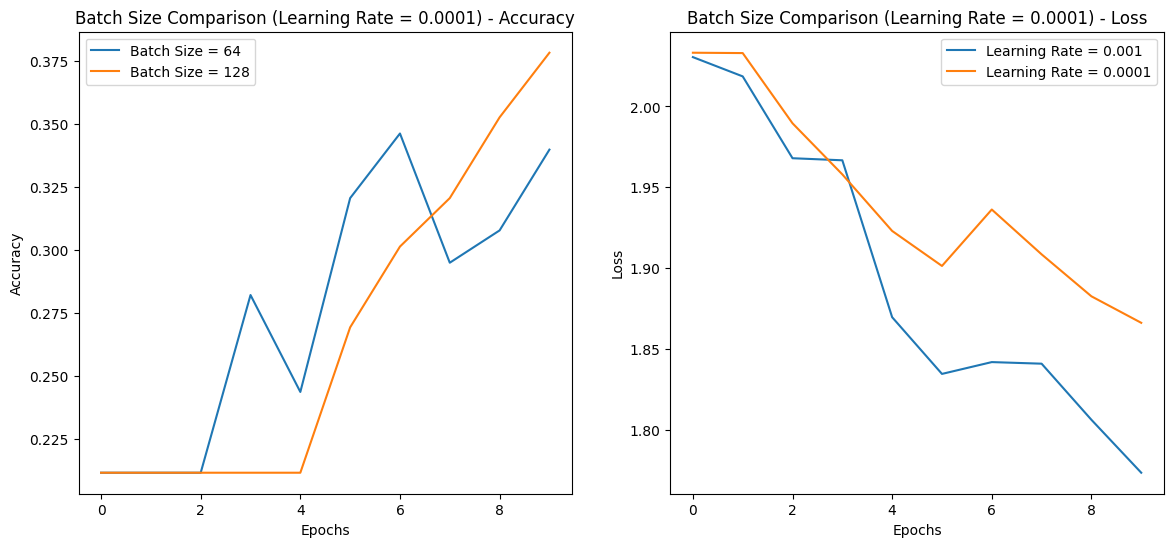

In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Accuracy Comparison
ax1.plot(va_64_low, label='Batch Size = 64')
ax1.plot(va_128_low, label='Batch Size = 128')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Batch Size Comparison (Learning Rate = 0.0001) - Accuracy')
ax1.legend()

# Subplot 2: Loss Comparison
ax2.plot(vl_64_low, label='Learning Rate = 0.001')
ax2.plot(vl_128_low, label='Learning Rate = 0.0001')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Batch Size Comparison (Learning Rate = 0.0001) - Loss')
ax2.legend()


plt.show()

### 4.5.3 Graph 3: Comparison of Loss and Accuracy for Different Learning Rates (Batch Size: 128) in ResidualCNN Model




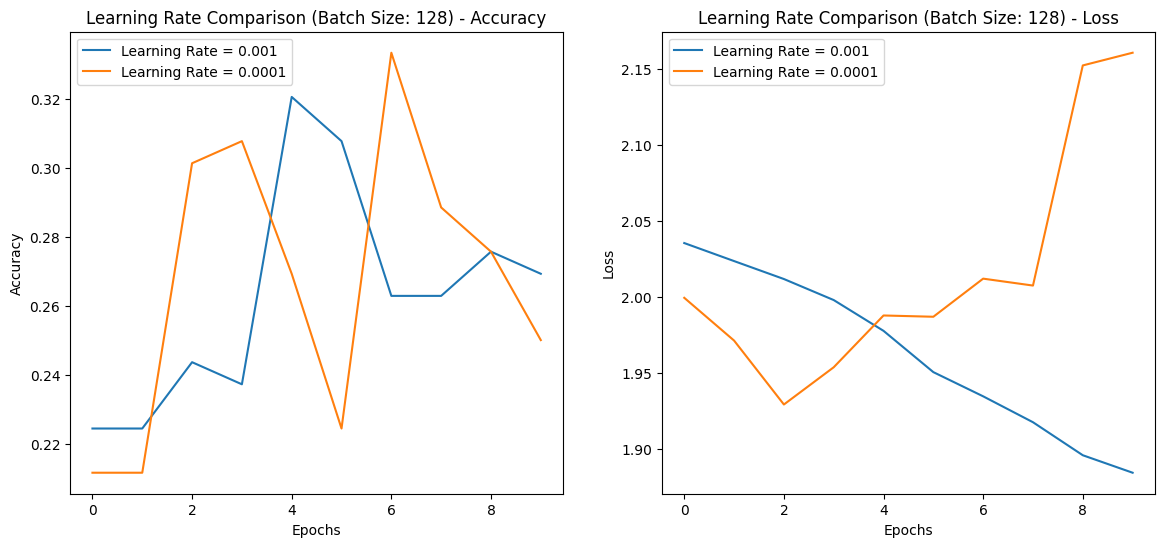

In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Accuracy Comparison
ax1.plot(residual_va_128_low, label='Learning Rate = 0.001')
ax1.plot(residual_va_128_high, label='Learning Rate = 0.0001')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Learning Rate Comparison (Batch Size: 128) - Accuracy')
ax1.legend()

# Subplot 2: Loss Comparison
ax2.plot(residual_vl_128_low, label='Learning Rate = 0.001')
ax2.plot(residual_vl_128_high, label='Learning Rate = 0.0001')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Learning Rate Comparison (Batch Size: 128) - Loss')
ax2.legend()


plt.show()

### 4.5.4 Graph 4: Comparison of Loss and Accuracy for Different Batch size (Learning Rate = 0.0001) in ResiudalCNNModel

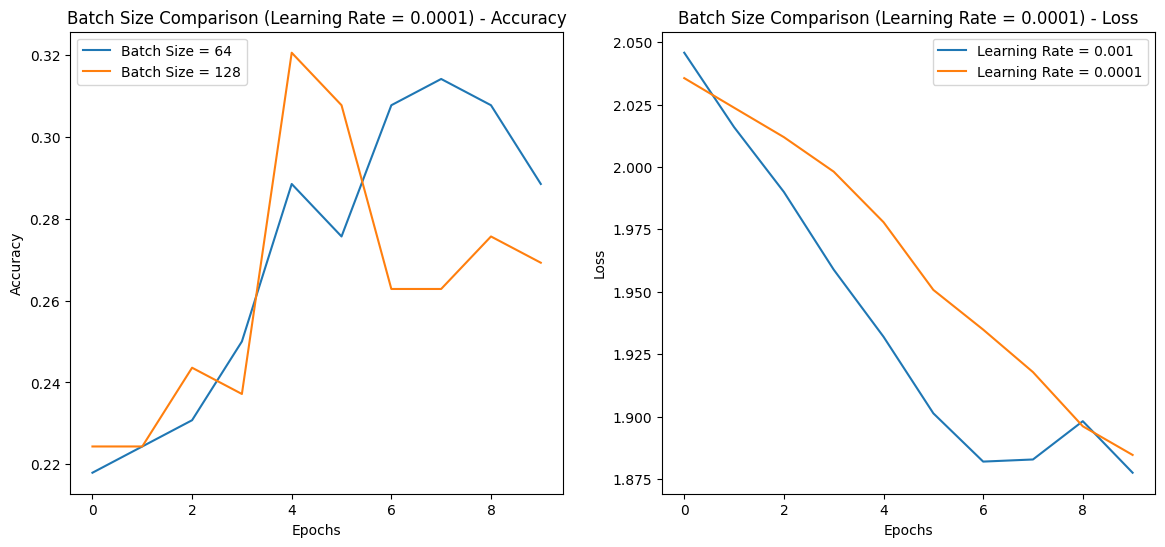

In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Accuracy Comparison
ax1.plot(residual_va_64_low, label='Batch Size = 64')
ax1.plot(residual_va_128_low, label='Batch Size = 128')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Batch Size Comparison (Learning Rate = 0.0001) - Accuracy')
ax1.legend()

# Subplot 2: Loss Comparison
ax2.plot(residual_vl_64_low, label='Learning Rate = 0.001')
ax2.plot(residual_vl_128_low, label='Learning Rate = 0.0001')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Batch Size Comparison (Learning Rate = 0.0001) - Loss')
ax2.legend()


plt.show()

## 4.6 Dropout Best Model

In [ ]:
import torch.nn.functional as F

class Net_vgg16(nn.Module):
    def __init__(self, dropout_bool = False):
        super().__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_bool = dropout_bool
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(25088 , 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 8)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        if self.dropout_bool:
            x = self.dropout(x)
        x = F.relu(self.fc2(x))
        if self.dropout_bool:
            x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
droput_model = Net_vgg16(dropout_bool=True).to(device=device)


dropout_vl, dropout_va, droput_model = train_and_validate(residual_model, train_dataset, val_dataset, 64,10, 0.0001)
np.save('files/dropout_vl.npy', dropout_vl)
np.save('files/dropout_va.npy', dropout_va)
torch.save(droput_model.state_dict(), 'files/droput_model.pt')

Epoch [1/10], Validation Loss: 1.9260, Validation Accuracy: 0.2885
Epoch [2/10], Validation Loss: 1.9286, Validation Accuracy: 0.2756
Epoch [3/10], Validation Loss: 1.9389, Validation Accuracy: 0.2949
Epoch [4/10], Validation Loss: 1.9364, Validation Accuracy: 0.2949
Epoch [5/10], Validation Loss: 1.9397, Validation Accuracy: 0.3141
Epoch [6/10], Validation Loss: 1.9402, Validation Accuracy: 0.3269
Epoch [7/10], Validation Loss: 1.9388, Validation Accuracy: 0.3205
Epoch [8/10], Validation Loss: 1.9294, Validation Accuracy: 0.3269
Epoch [9/10], Validation Loss: 1.9322, Validation Accuracy: 0.3462
Epoch [10/10], Validation Loss: 1.9474, Validation Accuracy: 0.3269


## 4.7 Best Model

In [ ]:
def predict_model(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    was_training = model.training
    model.eval()
    y_true = list()
    y_preds = list()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
           
            _, preds = torch.max(outputs, 1)
          

            for j in range(inputs.size()[0]):
                y_true.append(int(labels[j]))                
                y_preds.append(int(preds[j]))            

        model.train(mode=was_training)
        
    return y_true, y_preds

In [ ]:
y_true, y_pred = predict_model(residual_model_128_low, test_loader)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
accuracy_fe = accuracy_score(y_true, y_pred)
precision_fe = precision_score(y_true, y_pred, average="weighted")
recall_fe = recall_score(y_true, y_pred, average="weighted")
f1_fe = f1_score(y_true, y_pred, average="weighted")
cm_fe = confusion_matrix(y_true, y_pred)

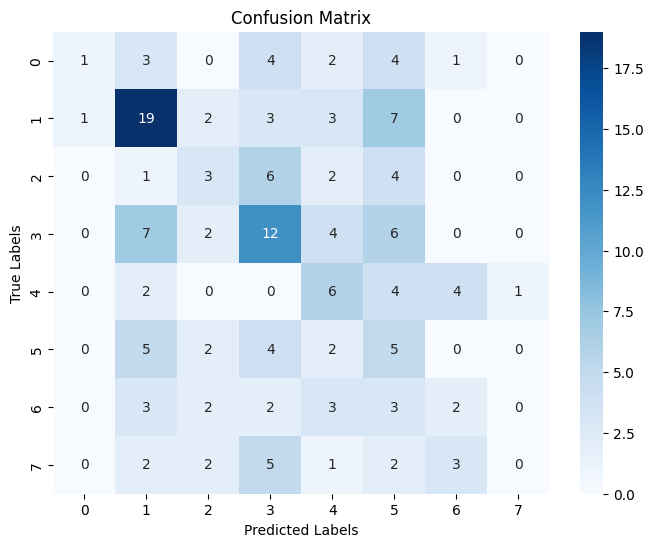

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fe, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 4.8 Part 1: Conclusion

Based on the evaluation of different batch sizes (128 and 64) and learning rates (0.001 and 0.0001) in both the CNN model and the residual model, as well as the inclusion of the dropout model, the best result was observed with a batch size of 128 and a learning rate of 0.0001.

The choice of batch size plays a crucial role in training deep learning models. A larger batch size can provide more stable gradients, leading to faster convergence. However, it may also require more memory and computational resources. In this case, the batch size of 128 resulted in better performance compared to 64, indicating that a larger batch size was beneficial for the model.

Regarding the learning rate, it determines the step size at each iteration during the optimization process. A higher learning rate can lead to faster convergence, but it may also cause overshooting and result in unstable training. On the other hand, a lower learning rate can lead to slower convergence but can potentially achieve better results in terms of accuracy. In this case, the learning rate of 0.0001 outperformed 0.001, suggesting that a lower learning rate was more suitable for this particular problem.

Comparing the CNN model and the residual model, the best performance was achieved with the CNN model. The residual model, which incorporates skip connections to facilitate the flow of gradients, did not provide significant improvements in this scenario. This suggests that for the given dataset and problem, the CNN model alone was sufficient to achieve good performance.

# 5 PART 2 - Transfer Learning with CNNs

In this section of the assignment, I utilized the pre-trained ResNet-18 convolutional neural network and fine-tuned it to classify the sample images. Fine-tuning the network allowed me to leverage the knowledge captured by the pre-trained model and adapt it to my specific task. This approach enabled me to train powerful and efficient models by utilizing the pre-trained weights and then training the model further with my own data. By fine-tuning the network, I was able to significantly enhance the performance and accuracy of the models.





<b>Question</b>: What is fine-tuning? Why should we do this? Why do we freeze the rest and train only FC layers?

<b>Answer</b>: Because the initial layers of a deep convolutional neural network (CNN) capture low-level and generic information like edges and textures, we freeze the majority of the pre-trained network's levels and only train the fully connected (FC) layers. These characteristics are frequently applicable and helpful in a variety of activities and datasets. We make sure to keep these general features that the pre-trained network has learned by freezing these layers.

On the other hand, the FC layers must be modified for the new task or dataset because they are in charge of learning task-specific information and making predictions. As a result, we only train the FC layers and leave the rest of the network frozen. This method minimizes the risk of overfitting and allows us to efficiently fine-tune the network, especially when the new dataset is small.

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Freeze all layers except the last FC layer
for param in model.parameters():
    param.requires_grad = False

# Modify the last FC layer for our new number of classes
num_classes = 8
model.fc = nn.Linear(model.fc.in_features, num_classes)


# Move model to device
model = model.to(device)

In [61]:
# Training loop for fine-tuning the FC layer
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total

    return train_loss, train_accuracy


In [62]:
# Evaluation loop
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    accuracy = 100.0 * correct / total
    avg_loss = running_loss / len(data_loader)

    return avg_loss, accuracy, predictions, targets

## 5.1 Freeze all layer, except FC Layer

In [64]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Train only the FC layer
fc_only_model = model


num_epochs = 10
best_accuracy_fc_only = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(fc_only_model, train_loader, criterion, optimizer)
    _, val_accuracy, _, _ = evaluate(fc_only_model, test_loader)
    if val_accuracy > best_accuracy_fc_only:
        best_accuracy_fc_only = val_accuracy
        best_model_fc_only = fc_only_model.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")




Epoch 1/10, Train Loss: 2.0448, Train Accuracy: 25.05%, Val Accuracy: 24.07%
Epoch 2/10, Train Loss: 1.9271, Train Accuracy: 28.87%, Val Accuracy: 27.78%
Epoch 3/10, Train Loss: 1.7840, Train Accuracy: 33.12%, Val Accuracy: 26.54%
Epoch 4/10, Train Loss: 1.6358, Train Accuracy: 40.98%, Val Accuracy: 28.40%
Epoch 5/10, Train Loss: 1.5163, Train Accuracy: 48.83%, Val Accuracy: 33.95%
Epoch 6/10, Train Loss: 1.4186, Train Accuracy: 53.50%, Val Accuracy: 35.19%
Epoch 7/10, Train Loss: 1.3447, Train Accuracy: 54.35%, Val Accuracy: 37.04%
Epoch 8/10, Train Loss: 1.3050, Train Accuracy: 60.51%, Val Accuracy: 39.51%
Epoch 9/10, Train Loss: 1.2795, Train Accuracy: 62.21%, Val Accuracy: 41.36%
Epoch 10/10, Train Loss: 1.2286, Train Accuracy: 60.93%, Val Accuracy: 38.89%


##  5.2 Freeze all layer, except two layer and FC Layer


In [65]:
# Train last two convolutional layers and FC layer
last_two_layers_model = model
for param in last_two_layers_model.layer4.parameters():
    param.requires_grad = True

optimizer = optim.SGD(last_two_layers_model.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10
best_accuracy_last_two_layers = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(last_two_layers_model, train_loader, criterion, optimizer)
    _, val_accuracy, _, _ = evaluate(last_two_layers_model, test_loader)

    if val_accuracy > best_accuracy_last_two_layers:
        best_accuracy_last_two_layers = val_accuracy
        best_model_last_two_layers = last_two_layers_model.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 1.1447, Train Accuracy: 63.48%, Val Accuracy: 41.36%
Epoch 2/10, Train Loss: 1.0835, Train Accuracy: 67.94%, Val Accuracy: 42.59%
Epoch 3/10, Train Loss: 0.9066, Train Accuracy: 74.73%, Val Accuracy: 47.53%
Epoch 4/10, Train Loss: 0.7392, Train Accuracy: 82.80%, Val Accuracy: 46.30%
Epoch 5/10, Train Loss: 0.6466, Train Accuracy: 84.71%, Val Accuracy: 49.38%
Epoch 6/10, Train Loss: 0.5835, Train Accuracy: 88.11%, Val Accuracy: 51.23%
Epoch 7/10, Train Loss: 0.4893, Train Accuracy: 91.93%, Val Accuracy: 50.00%
Epoch 8/10, Train Loss: 0.4512, Train Accuracy: 92.36%, Val Accuracy: 50.00%
Epoch 9/10, Train Loss: 0.3515, Train Accuracy: 94.06%, Val Accuracy: 51.23%
Epoch 10/10, Train Loss: 0.3201, Train Accuracy: 95.12%, Val Accuracy: 51.23%


## 5.3 Best Model

In [66]:
# Evaluate best models
_, test_accuracy_fc_only, test_predictions_fc_only, test_targets_fc_only = evaluate(model, test_loader)
_, test_accuracy_last_two_layers, test_predictions_last_two_layers, test_targets_last_two_layers = evaluate(last_two_layers_model, test_loader)


In [70]:
def predict_model(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    was_training = model.training
    model.eval()
    y_true = list()
    y_preds = list()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
           
            _, preds = torch.max(outputs, 1)
          

            for j in range(inputs.size()[0]):
                y_true.append(int(labels[j]))                
                y_preds.append(int(preds[j]))            

        model.train(mode=was_training)
        
    return y_true, y_preds

In [71]:
y_true, y_pred = predict_model(last_two_layers_model, test_loader)

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
accuracy_fe = accuracy_score(y_true, y_pred)
precision_fe = precision_score(y_true, y_pred, average="weighted")
recall_fe = recall_score(y_true, y_pred, average="weighted")
f1_fe = f1_score(y_true, y_pred, average="weighted")
cm_fe = confusion_matrix(y_true, y_pred)

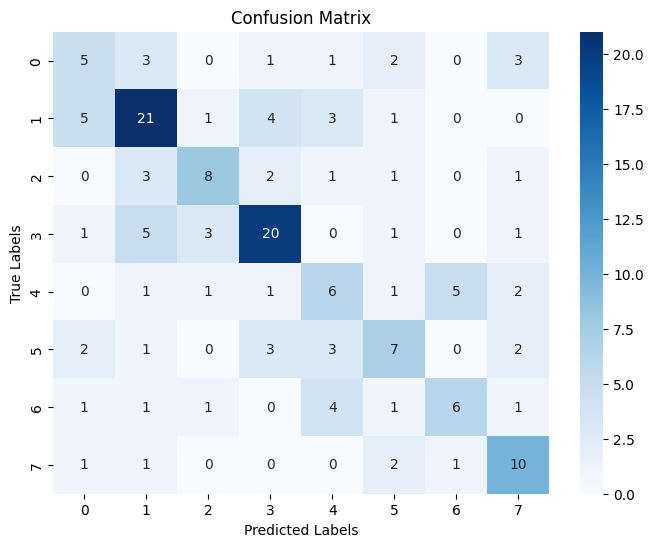

In [73]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fe, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 5.4 Part-1 and Part-2 Analysis


In Part 1, we trained a convolutional neural network (CNN) model on a given dataset. We used a visual dataset that involved classifying two different conditions and trained the model accordingly. We defined the architecture of the model, loaded the dataset, and preprocessed the data. Next, we constructed the CNN layers and trained the model while evaluating its performance on the validation set. The results obtained in Part 1 allowed us to assess the model's performance and generalization.

In Part 2, we focused on fine-tuning a pre-trained ResNet-18 model. Fine-tuning involves utilizing a pre-trained model and adapting it to our specific task. We froze the majority of the model's layers, except for the fully connected (FC) layer, which we trained. By doing so, we leveraged the knowledge captured by the pre-trained model, enabling us to enhance the model's performance. Additionally, we modified the last layer of the network, initializing its weights randomly to match the number of classes in our dataset. We experimented with training only the FC layer and freezing the rest, as well as training the last two convolutional layers along with the FC layer while freezing the remaining layers. By comparing and analyzing the results, we identified the best model with the highest accuracy on the validation set. Furthermore, we plotted a confusion matrix to gain insights into the model's predictions and performance for each class. This analysis provided valuable information about the model's strengths and weaknesses, highlighting areas for further improvement.

Overall, both Part 1 and Part 2 of the assignment allowed us to gain knowledge and experience in model training, transfer learning, and fine-tuning. The results obtained in Part 2 demonstrated the effectiveness of leveraging pre-trained models and fine-tuning them for improved performance.